# Statistical hypothesis testing - 16th march 2023

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

import warnings
warnings.filterwarnings("ignore")

# Exercise 1

In [2]:
N_bins = 100
mu_bg = np.array([0.1, 10, 1000])
mu_sig = 0
N = int(1e5)

mu_i_bg = mu_bg

In [3]:
def calc_lamb(x1, N_tot):
    return 2*x1*np.log(N_bins/N_tot*x1) + 2*(N_tot-x1)*np.log(N_bins/N_tot*(N_tot-x1)/(N_bins-1))

In [4]:
def test(mu_bg, mu_sig):
    lamb_values = []
    
    for i in range(N):
        bg =  np.random.poisson(mu_bg, N_bins)
        sig = np.random.poisson(mu_sig)
        bg[0] += sig
        lamb = calc_lamb(bg[0], np.sum(bg))
        lamb_values.append(lamb)

    return lamb_values

In [5]:
#test(mu_i_bg[0], mu_sig)

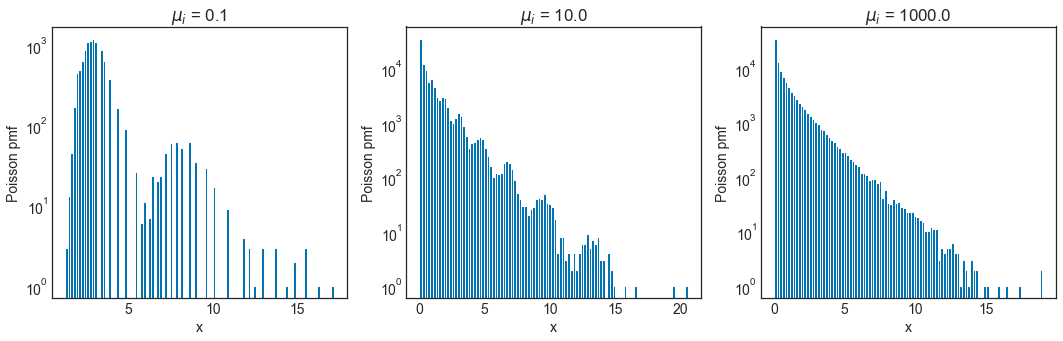

In [6]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
for i, mu_i in enumerate(mu_i_bg):
    lamb_values = test(mu_i, mu_sig)
    axes[i].hist(lamb_values, bins=N_bins)
    axes[i].set(xlabel = 'x', ylabel = 'Poisson pmf', title = r'$\mu_i$ = %s' %(mu_i), yscale = 'log')

In [7]:
mu_bg_star = 1000
mu_sig = np.array([100, 200])

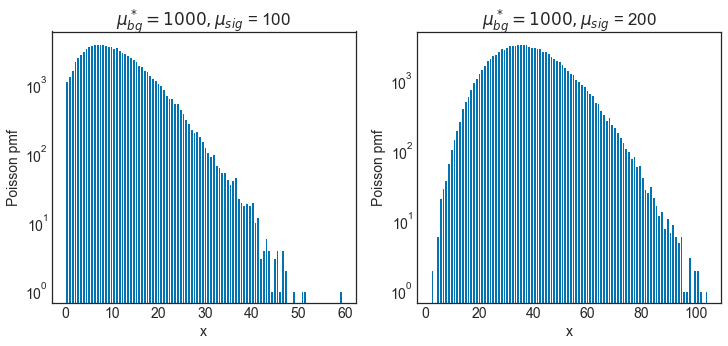

In [8]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
for i, mu_i_sig in enumerate(mu_sig):
    lamb_values = test(mu_bg_star, mu_i_sig)
    axes[i].hist(lamb_values, bins=N_bins)
    axes[i].set(xlabel = 'x', ylabel = 'Poisson pmf', title = r'$\mu_{bg}^* = 1000, \mu_{sig}$ = %s' %(mu_i_sig), yscale = 'log')

In [9]:
data1 = test(mu_bg_star, 0)
data2 = test(mu_bg_star, 100)
data3 = test(mu_bg_star, 200)

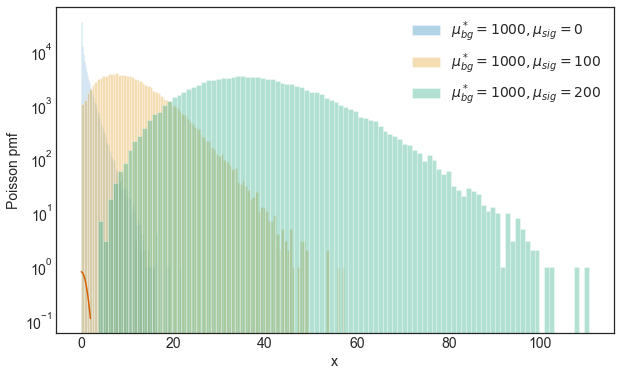

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(data1, bins=N_bins, label = '$\mu_{bg}^* = 1000, \mu_{sig} = 0$', alpha=0.3)
ax.hist(data2, bins=N_bins, label = '$\mu_{bg}^* = 1000, \mu_{sig} = 100$', alpha=0.3)
ax.hist(data3, bins=N_bins, label = '$\mu_{bg}^* = 1000, \mu_{sig} = 200$', alpha=0.3)
ax.set(xlabel = 'x', ylabel = 'Poisson pmf', yscale = 'log')
x = np.linspace(0, 2, 1000)
ax.plot(x, scipy.stats.chi.pdf(x, df=1))
ax.legend();

## Exercise 2

In [11]:
import healpy as H
import sys
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
import pickle

In [12]:
N_points = 10
azi = np.random.uniform(0, 360, N_points)
zen = np.random.uniform(0, 360, N_points)

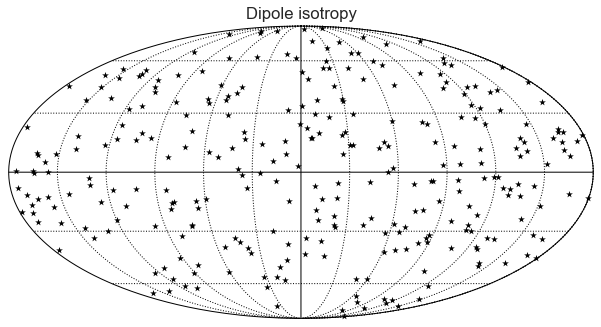

In [13]:
# Color map
my_cmap = sns.color_palette('Greys', 256)

# Creating map
nside = 32
npix = H.nside2npix(nside)
map = np.zeros(npix,dtype=int)
H.mollview(map, min=0,max=1,cbar=False, title = 'Dipole isotropy', cmap='Greys')
H.graticule()

# Number of stars
Ntot = 300


theta = []
phi = []
nx = []
ny = []
nz = []

# Cumulative two-point auto-correlation function 
for i in range(0,Ntot) :
    phitemp = np.random.rand()*2*np.pi
    x = np.random.rand()
        
    # dipole anisotropy 
    ani = 0.9 # parameter between -1.0 and 1.0
    costhetatemp = (1.-np.sqrt(1.0+2.*ani+ani**2-4.*ani*x))/ani
        
    #isotropic 
    costhetatemp = 2.0*x-1.0
    thetatemp = np.arccos(costhetatemp)
        
    nxtemp = np.cos(phitemp)*np.sin(thetatemp)
    nytemp = np.sin(phitemp)*np.sin(thetatemp)
    nztemp = np.cos(thetatemp)
        
    phi.append(phitemp)
    theta.append(thetatemp)
    nx.append(nxtemp)
    ny.append(nytemp)
    nz.append(nztemp)
        
    # Plot stars    
    H.projscatter(thetatemp,phitemp,marker='*',s=50,color='black',linewidth=0)

In [14]:
def cum_auto_corr(Ntot, ax=ax):
    cosphi = []
    for i in range(0,Ntot):
        for j in range(0,i):
            cosphitemp = nx[i]*nx[j] + ny[i]*ny[j] + nz[i]*nz[j]
            cosphi.append(cosphitemp)
            
    
    totpairs = len(cosphi)
    Nbins = 100
    y = np.zeros(Nbins,dtype=int)
    cosx = np.arange(0,Nbins)/(1.0*Nbins)*2.0-1.0
    x = np.arccos(cosx)

    for i in range(0,totpairs) :
        bin = int((cosphi[i]+1.)/2.*Nbins)
        y[bin] += 1

    sumy = np.zeros(Nbins,dtype=int)


    for i in range(0,Nbins) :
        for j in range(i+1,Nbins) :
            sumy[i] += y[j]

    sumy = sumy/(1.*totpairs)
    sumyiso = 1./2.*(1.0-cosx)

    KS = np.max(np.abs(sumy-sumyiso))
    KSindex = np.argmax(np.abs(sumy-sumyiso))

    #fig = plt.figure(figsize=(6, 6))
    #ax = fig.add_subplot(1,1,1)
    ax.set_title(r'simulation (' + str(Ntot) + ' events)',fontsize=16,y=1.05)
    ax.set_xlabel(r'$\cos\varphi$',fontsize=16)
    ax.set_ylabel(r'cumulative auto-correlation $\mathcal{C}(\varphi)$',fontsize=16)
    ax.tick_params(axis='both',which='both',direction='in')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)  

    ax.set_xlim([-1,1])
    ax.set_ylim([0,1])
    ax.plot(cosx,sumy,drawstyle='steps-mid',label=r'dipole')
    ax.plot(cosx,sumyiso,drawstyle='steps-mid',label=r'isotropic')
    ax.plot(np.array([cosx[KSindex],cosx[KSindex]]),np.array([sumy[KSindex],sumyiso[KSindex]]),color='red',linewidth=2.0,label='$KS = ' + '{:.2f}'.format(KS) + '$')

    leg = ax.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.,fancybox=False,framealpha=0.0,frameon=True,numpoints=1, scatterpoints = 1,handlelength=1)
    for t in leg.get_texts() :
        t.set_fontsize(14)

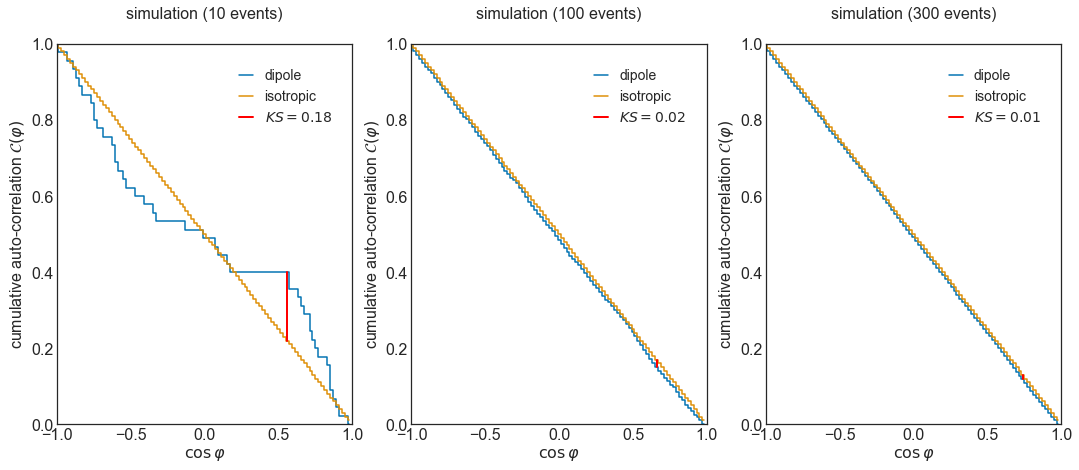

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,7))
cum_auto_corr(10, ax=ax1)
cum_auto_corr(100, ax=ax2)
cum_auto_corr(300, ax=ax3)

A chaos values (KS) means nothing alone